In [1]:
import argparse
import numpy as np
import seaborn as sns
from tools.fileOps import *
from tools.procOps import *
from tools.transcripts import *
from tools.bio import *
from pyfasta import Fasta
import pysam
from collections import *
from itertools import *
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
scaffolds_bam = '../E2del19N/E2del19N.consensus_mapped.sorted.bam'
reads_fq = '../E2del19N/E2del19N.fastq'
scaffold_fa = '/hive/users/ifiddes/notch2nl_berkeley_data/E2del19N_E2del68_combined_longranger/E2del68_E2del19N_combined/new-assembly/scaffolded.fa'
tmp_fq = 'tmp.fq'
tmp_sam = 'tmp.sam'
cmd = ['samtools', 'fastq', scaffolds_bam]
run_proc(cmd, stdout=tmp_fq)
cmd = ['bwa', 'mem', '-t', '12', scaffold_fa, reads_fq]
run_proc(cmd, stdout=tmp_sam)

In [183]:
# load barcode map
bcode_map = {}
for x in open(reads_fq):
    if x.startswith('@'):
        name, bcode = x.split()
        name = name[1:-2]
        bcode_map[name] = bcode

# divide reads by barcode
sh = pysam.Samfile(tmp_sam)
s = defaultdict(list)
for x in sh:
    if not x.is_unmapped:
        if x.mapq > 0:
            bcode = bcode_map[x.qname]
            s[bcode].append(x)

In [184]:
# find haplotype with highest average mapq
by_avg = {}
for bcode, reads in s.iteritems():
    if len(reads) < 10:
        continue
    by_tgt = defaultdict(list)
    for r in reads:
        by_tgt[r.reference_name].append([r, r.mapq])
    sums = {}
    for rname, rname_vals in by_tgt.iteritems():
        rname_reads, mapqs = zip(*rname_vals)
        sums[rname] = sum(mapqs)
    if all([x == 0 for x in sums.itervalues()]):
        continue
    ordered = sorted(sums.iteritems(), key=lambda x:x[1])
    best_name, best_score = ordered[-1]
    mappings = [x for x in reads if x.reference_name == best_name]
    by_avg[bcode] = mappings


In [185]:
# transform to be by-ref
by_ref_avg = defaultdict(list)
by_ref_sum = defaultdict(list)
for bcode, mappings in by_avg.iteritems():
    mapqs = [x.mapq for x in mappings]
    avg = np.mean(mapqs)
    by_ref_avg[mappings[0].reference_name].append(avg)
    by_ref_sum[mappings[0].reference_name].append(sum(mapqs))

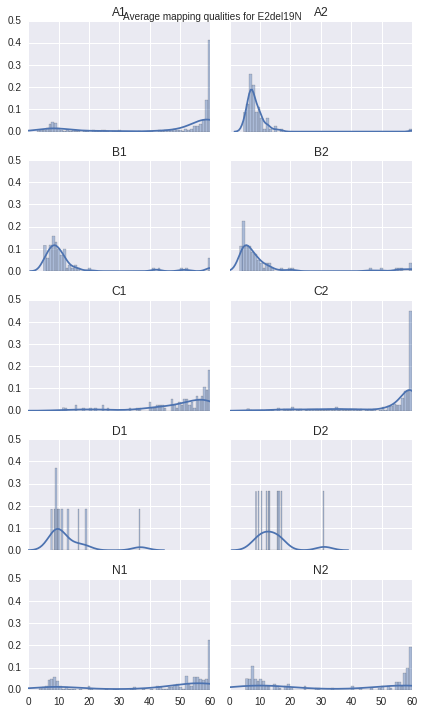

In [186]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True)
figsize(6, 10)
axes = iter(axes.flat)
axes[0].set_xlim(0, 60)
for name, avg_vals in sorted(by_ref_avg.iteritems(), key=lambda x: x[0]):
    g = sns.distplot(avg_vals, ax=axes.next(), bins=60)
    g.set_title(name)
plt.tight_layout()
fig.suptitle('Average mapping qualities for E2del19N')

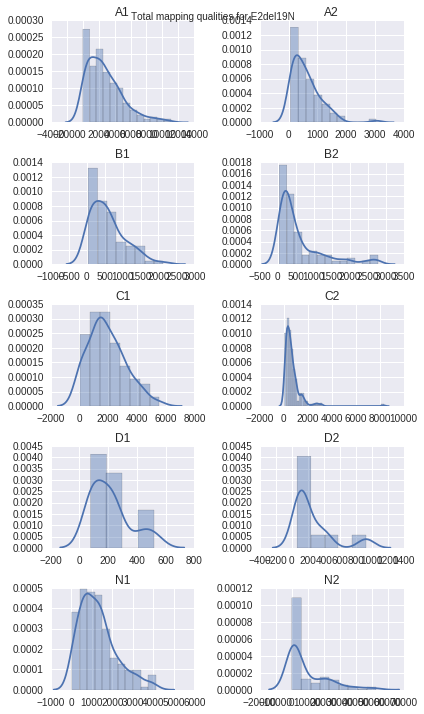

In [187]:
fig, axes = plt.subplots(nrows=5, ncols=2)
figsize(6, 10)
axes = iter(axes.flat)
for name, sum_vals in sorted(by_ref_sum.iteritems(), key=lambda x: x[0]):
    g = sns.distplot(sum_vals, ax=axes.next())
    g.set_title(name)
plt.tight_layout()
fig.suptitle('Total mapping qualities for E2del19N')

In [188]:
# find delta to next best again, separate delta by name
# find haplotype with highest average mapq
delta_avg = defaultdict(list)
for bcode, reads in s.iteritems():
    if len(reads) < 10:
        continue
    by_tgt = defaultdict(list)
    for r in reads:
        by_tgt[r.reference_name].append([r, r.mapq])
    avgs = {}
    for rname, rname_vals in by_tgt.iteritems():
        rname_reads, mapqs = zip(*rname_vals)
        avgs[rname] = np.mean(mapqs)
    if all([x == 0 for x in avgs.itervalues()]):
        continue
    ordered = sorted(avgs.iteritems(), key=lambda x:x[1])
    best_name, best_score = ordered[-1]
    if len(ordered) > 1:
        if ordered[-2][1] == 0:
            continue
        delta = ordered[-1][1] - ordered[-2][1]
        name = ordered[-2][0]
        delta_avg[best_name].append([name, delta])

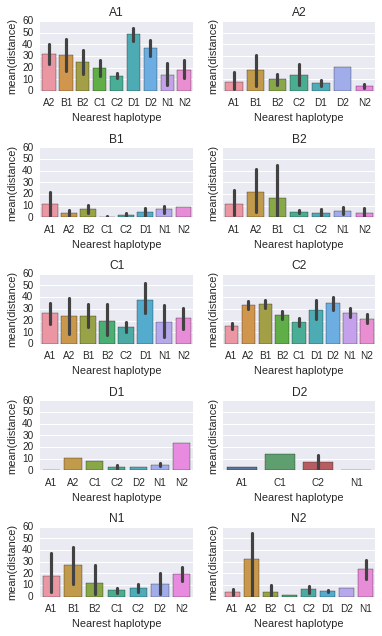

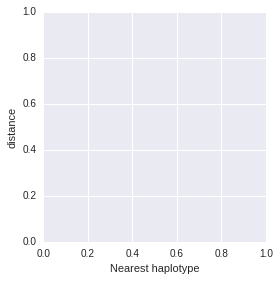

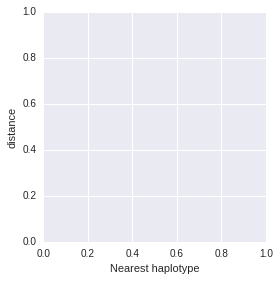

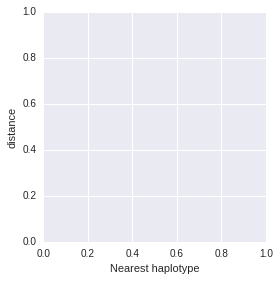

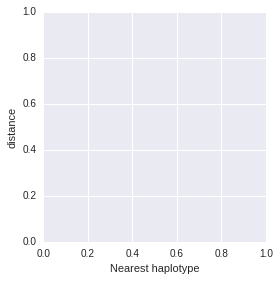

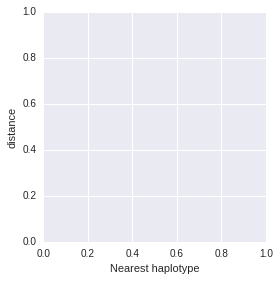

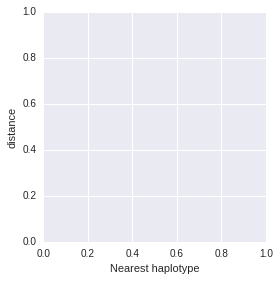

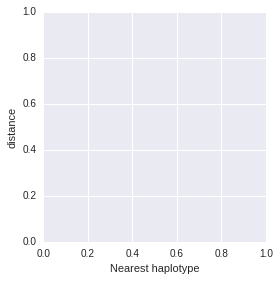

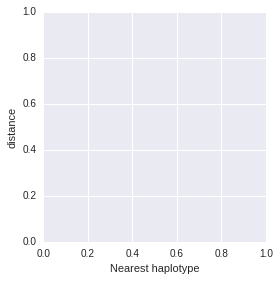

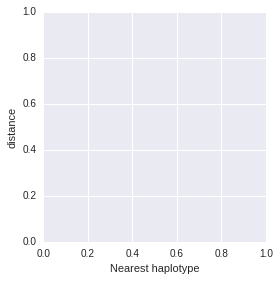

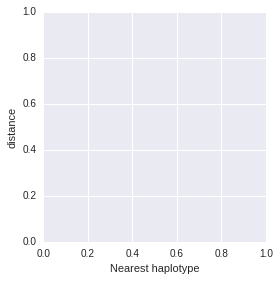

In [189]:
# for each reference, construct a plot showing the closest score
import pandas as pd
fig, axes = plt.subplots(nrows=5, ncols=2, sharey=True)
figsize(6, 10)
axes = iter(axes.flat)
plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.8)
for name, vals in sorted(delta_avg.iteritems(), key=lambda x: x[0]):
    df = pd.DataFrame(vals, columns=['Nearest haplotype', 'distance']).sort_values('Nearest haplotype')
    ax = axes.next()
    g = sns.factorplot(data=df, y='distance', kind='bar', x='Nearest haplotype', ax=ax)
    ax.set_title(name)
